### Import

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Data1: NN

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

### Lightning module

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=2, hidden_units=32, num_classes=1):
        """
        Args:
            input_features (int): Number of input features (2 for your data)
            hidden_units (int): Number of neurons in the hidden layer
            num_classes (int): Number of output classes (1 for binary)
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            # --- Hidden Layer 1 ---
            # Takes 2 features in, outputs a hidden representation of size 32
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),  # <-- The crucial non-linear activation function

            # --- Output Layer ---
            # Takes the 16-unit hidden representation, outputs 1 logit
            nn.Linear(in_features=hidden_units, out_features=num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, hidden_units=32, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

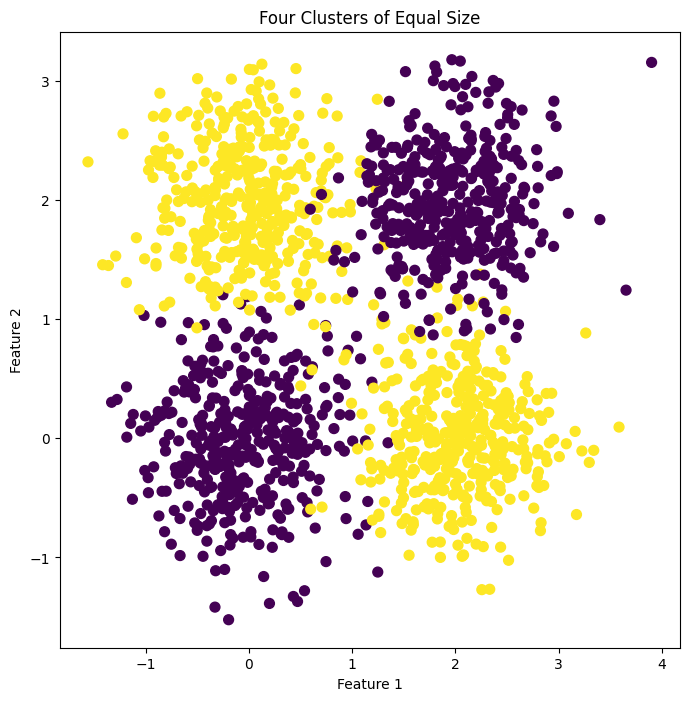

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)


In [8]:
from sklearn.model_selection import KFold

train_data, test_data, val_data = generate_data("data1")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


### Regular training

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='simple-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Starting Training for 1 epochs on train_loader ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 56.60it/s, v_num=15]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 54.41it/s, v_num=15]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v14.ckpt



Best model from Phase 1 saved to: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v14.ckpt

--- Testing model from Phase 1 checkpoint: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v14.ckpt ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 249.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.4458
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 97.74it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7087163925170898
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on 

### Weighted ROC curve

In [10]:
NUM_CLASSIFIERS = 50
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    # 1. Instantiate the LightningModule
    model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE, pos_weight=pos_weight)
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    fold_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)


    for i, pos_weight in enumerate(pos_weights):
        
        
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{fold+1}_ratio_{pos_weight}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




Seed set to 42


--- Starting Fold 1/4 ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 81.17it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 76.97it/s, v_num=0]
--- Fold 1 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Testing model after Fold 1 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 56.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4002
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 54.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.25389400124549866
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.82it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.27it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.4557
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 210.10it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.28766369819641113
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.00it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.21it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 256.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.4806
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 209.29it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4331889748573303
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.21it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.62it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 4 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v13.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.6032
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.54it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.31169965863227844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.88it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.68it/s, v_num=0]
--- Fold 1 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Testing model after Fold 1 Stage 5 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v13.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 250.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5518
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 191.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2760787010192871
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 86.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 80.84it/s, v_num=0]
--- Fold 1 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Testing model after Fold 1 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4600
AUC: 0.4849
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 258.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3944533169269562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.77it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.58it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5516
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 239.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.29312288761138916
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.86it/s, v_num=0] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 92.62it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 8 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v13.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4283
AUC: 0.5237
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 263.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32270368933677673
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.24it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.07it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5870
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 246.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32604384422302246
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.28it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.73it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5400
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5876712799072266
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.35it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.40it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 439.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7570
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.34592360258102417
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.10it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.01it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 245.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6296
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 194.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3787596821784973
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.18it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.65it/s, v_num=0]
--- Fold 1 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 13 ---


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v12.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5741
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.13it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40021100640296936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.11it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.39it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3133
AUC: 0.5231
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.43794193863868713
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.51it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.24it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3083
AUC: 0.2422
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6062870621681213
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.09it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.66it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.6370
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 222.86it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.47683650255203247
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.01it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.60it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6817
AUC: 0.7846
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4935857653617859
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.98it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.23it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6633
AUC: 0.5522
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 267.46it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4993646740913391
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.90it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.18it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3467
AUC: 0.5428
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5594339370727539
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.31it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.64it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5767
AUC: 0.6741
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5331700444221497
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.69it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.30it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5200
AUC: 0.3825
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6125707030296326
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.83it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.40it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6983
AUC: 0.5560
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5811804533004761
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.14it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 99.37it/s, v_num=0] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 23 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v12.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 358.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5264
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6991685628890991
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.18it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.75it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5329
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6492299437522888
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.71it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.70it/s, v_num=0]
--- Fold 1 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Testing model after Fold 1 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4183
AUC: 0.5352
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 255.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6395387053489685
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.75it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.87it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.6544
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 264.84it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6845853924751282
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.49it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.63it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5185
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 261.13it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7840038537979126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.24it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.03it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.6973
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 253.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7401840686798096
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.34it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.13it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6633
AUC: 0.6375
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7736104130744934
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.05it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.22it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5600
AUC: 0.5644
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8054370880126953
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.48it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 94.58it/s, v_num=0] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 31 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v12.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4583
AUC: 0.4641
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9222288727760315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.48it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.16it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 470.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.4899
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9688120484352112
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 94.19it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 88.98it/s, v_num=0]
--- Fold 1 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Testing model after Fold 1 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 468.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.6779
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.32it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0760399103164673
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.14it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.55it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5450
AUC: 0.5225
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1001139879226685
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.00it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.79it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6433
AUC: 0.7987
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1266732215881348
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.84it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.56it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5290
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5137864351272583
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.49it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.22it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6333
AUC: 0.7511
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2686365842819214
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.70it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.68it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4283
AUC: 0.5659
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 259.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2516142129898071
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.50it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.05it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 464.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5902
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2911992073059082
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.53it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.86it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6283
AUC: 0.6686
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5177197456359863
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.86it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.40it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4167
AUC: 0.5136
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.9023468494415283
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.13it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.88it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 455.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.5230
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.161874771118164
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.38it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.37it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5783
AUC: 0.5153
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.0765397548675537
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.84it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.40it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4733
AUC: 0.3308
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.4069554805755615
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.17it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.16it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5883
AUC: 0.4631
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.1608896255493164
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.05it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.14it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4935
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.4672045707702637
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.95it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.14it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.5972
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            5.281833648681641
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.80it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.07it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3283
AUC: 0.2651
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            8.314030647277832
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.50it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.06it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.4234
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           13.349420547485352
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.84it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.97it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4500
AUC: 0.4702
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           432.40435791015625
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.45it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.22it/s, v_num=0]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v12.ckpt


--- Fold 2 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4483
AUC: 0.3231
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.388527512550354
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.08it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.17it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 463.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4117
AUC: 0.5977
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.26180800795555115
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.63it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.76it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3717
AUC: 0.4680
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.26974913477897644
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.74it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.45it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4392
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.27116072177886963
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.53it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.28it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5258
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.24948735535144806
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.68it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.78it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 480.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5269
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.32167309522628784
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.82it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.89it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4017
AUC: 0.3512
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3605138659477234
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.30it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.42it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5787
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2941030263900757
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.61it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.28it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5483
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3328615128993988
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.30it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.73it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5650
AUC: 0.6655
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3429880440235138
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.63it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.97it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 262.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.6182
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 210.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5253953337669373
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.40it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.70it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4567
AUC: 0.4991
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.46055179834365845
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.27it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.00it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.5335
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.39010295271873474
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.56it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.96it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6617
AUC: 0.4890
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4619099795818329
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.15it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.51it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4400
AUC: 0.5340
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.44603490829467773
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.08it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.50it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3450
AUC: 0.4201
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.500263512134552
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.27it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.23it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4850
AUC: 0.7153
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5185450315475464
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.33it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.66it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5650
AUC: 0.6753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5765458941459656
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.39it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.54it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6920
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 288.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5503715872764587
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.46it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.26it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.6643
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5296545624732971
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.02it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.37it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5250
AUC: 0.5949
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.574130117893219
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.37it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.97it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4937
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6034871339797974
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.39it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.03it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.4641
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6353976130485535
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.49it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.89it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.6581
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6477491855621338
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.01it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.75it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4850
AUC: 0.5395
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6830233335494995
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.87it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.45it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 441.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3900
AUC: 0.4174
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7523500919342041
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.42it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.76it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6633
AUC: 0.4619
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7295371294021606
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.23it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.86it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.6933
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7395385503768921
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.67it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.39it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.5900
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7809900045394897
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.37it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.00it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 450.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5517
AUC: 0.4858
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8998323678970337
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.61it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.41it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5423
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9085932374000549
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.76it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.74it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4500
AUC: 0.3672
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9397035837173462
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.75it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6017
AUC: 0.6287
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.894604504108429
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.19it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.03it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 427.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5032
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1058728694915771
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.53it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.29it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6200
AUC: 0.5155
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0903247594833374
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.28it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.80it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5333
AUC: 0.5710
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0821346044540405
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.15it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.29it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4310
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.201767921447754
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.15it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4583
AUC: 0.5394
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2442867755889893
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.69it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.4700
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 279.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.3802869319915771
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.33it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.90it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3350
AUC: 0.5198
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 262.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5264651775360107
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.35it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.62it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4383
AUC: 0.5299
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 245.82it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.9982374906539917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.23it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.75it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.4970
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.640191912651062
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.17it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.33it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.6817
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.6976523399353027
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.15it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.90it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 253.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5150
AUC: 0.4983
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 199.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.3053436279296875
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.51it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.38it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 268.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.4094
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 216.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             2.9836266040802
────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.02it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.88it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 435.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.6930
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            4.135490894317627
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.17it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.22it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4150
AUC: 0.4477
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            4.816271781921387
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.09it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.89it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3907
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            6.134882926940918
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.02it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.37it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.5437
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           11.487526893615723
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 159.21it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.50it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v12.ckpt



--- Fold 2 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 2 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4033
AUC: 0.1966
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            423.6180725097656
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 3/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.47it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.13it/s, v_num=0]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v12.ckpt


--- Fold 3 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4166
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.20914091169834137
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.28it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.27it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.5645
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2598850727081299
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.83it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6767
AUC: 0.4686
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.448415070772171
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.87it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.39it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.4305
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2729255259037018
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.96it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.74it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5258
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.33790042996406555
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.99it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.82it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6067
AUC: 0.4282
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4257926940917969
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.88it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.47it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6983
AUC: 0.5982
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.41817429661750793
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.52it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.76it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5555
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.28659939765930176
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.53it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.23it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4878
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3448657989501953
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.45it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.43it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 512.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5291
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.37978604435920715
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.26it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.33it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5353
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.39586126804351807
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.05it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.13it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.5496
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3998446762561798
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.49it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.30it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5202
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.39513930678367615
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.97it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.50it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5583
AUC: 0.7056
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.45453062653541565
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.29it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.95it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.6583
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4242202639579773
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.71it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.21it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2817
AUC: 0.4800
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5200661420822144
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.32it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.56it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 379.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5333
AUC: 0.4694
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.98it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5133623480796814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.64it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.86it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6933
AUC: 0.5785
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.49031317234039307
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.44it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.83it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 486.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5238
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5223210453987122
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.93it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.79it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 474.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8831
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5275863409042358
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.34it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.61it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 522.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5156
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5814039707183838
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.76it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.68it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7267
AUC: 0.5426
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6044496893882751
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.65it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.80it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.5608
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6232190728187561
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.46it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.93it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6933
AUC: 0.6936
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6173145174980164
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.89it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.07it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4209
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.718671441078186
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.97it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.70it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6533
AUC: 0.4767
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7108905911445618
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.56it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.40it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.9102
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7204319834709167
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.49it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.00it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4100
AUC: 0.5490
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7546918988227844
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.77it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.95it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5483
AUC: 0.4751
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7943838238716125
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.63it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.29it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.5258
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8528054356575012
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.08it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.93it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4467
AUC: 0.5636
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.910354495048523
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.58it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.02it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4550
AUC: 0.5072
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9376383423805237
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.59it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.24it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 257.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4433
AUC: 0.4548
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 215.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0859240293502808
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.16it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.20it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 446.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.4689
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0253982543945312
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.24it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.56it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4850
AUC: 0.5410
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1074597835540771
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.46it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.45it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5883
AUC: 0.6420
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 243.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1469720602035522
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.58it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.28it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.4148
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1868559122085571
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.52it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.74it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 379.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.4824
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2521039247512817
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.16it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.76it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4633
AUC: 0.4193
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.550992488861084
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.11it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.22it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6530
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4106143712997437
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.84it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.98it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.4602
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.7306230068206787
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.99it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.97it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3083
AUC: 0.4968
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8169080018997192
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.88it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.48it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4927
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6758924722671509
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.92it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.01it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5339
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.038492441177368
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.85it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.82it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4750
AUC: 0.3695
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.6141655445098877
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.16it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.45it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.5428
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            4.769218921661377
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.69it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.54it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5957
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.7295572757720947
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.29it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.12it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5450
AUC: 0.6312
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            8.363389015197754
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.49it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.16it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.3434
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           19.106374740600586
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.40it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.56it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v12.ckpt



--- Fold 3 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 3 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4117
AUC: 0.5389
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            248.4932098388672
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 4/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.41it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.72it/s, v_num=0]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.8377
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36201536655426025
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.63it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.29it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.5836
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3203478455543518
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.44it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.03it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3933
AUC: 0.5138
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2815231382846832
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.54it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.99it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5300
AUC: 0.5573
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.277118057012558
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.25it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.55it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.6234
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3700118362903595
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.15it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.74it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5933
AUC: 0.4587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36034348607063293
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.80it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.49it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7649
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.30782070755958557
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.55it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.64it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 518.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4250
AUC: 0.5351
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4377998411655426
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.07it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.73it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5767
AUC: 0.6628
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.39508241415023804
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.22it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.86it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4117
AUC: 0.5628
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.39641982316970825
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.77it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.75it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 267.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4533
AUC: 0.5694
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 224.76it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.41297289729118347
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.98it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.03it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4926
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3714388906955719
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.56it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.49it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4700
AUC: 0.4484
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.46619802713394165
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.75it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.87it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5283
AUC: 0.5715
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4181097447872162
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.71it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.51it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4279
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4557783603668213
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.34it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.89it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.5437
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.46169236302375793
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.89it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.96it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 227.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5680
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 183.21it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.4861687123775482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.82it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.24it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 472.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4250
AUC: 0.5868
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5080609917640686
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.56it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.81it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6833
AUC: 0.5565
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5326439142227173
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.14it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.53it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 527.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5850
AUC: 0.5094
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6068235635757446
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.12it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.71it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6467
AUC: 0.5349
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6206458806991577
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.35it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.81it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5267
AUC: 0.8236
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.593399703502655
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.38it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.54it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6350
AUC: 0.5005
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6195981502532959
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.52it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.87it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5483
AUC: 0.5119
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6770352125167847
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.43it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.23it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 354.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5433
AUC: 0.5482
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 280.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6846100091934204
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.62it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.49it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3533
AUC: 0.5614
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.35it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7027724385261536
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.36it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.93it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5317
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8143728971481323
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.67it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.59it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 529.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.8050
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7106540203094482
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.86it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.52it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.4334
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.848698616027832
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.56it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.97it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5592
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 279.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8247833847999573
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.96it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.18it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6417
AUC: 0.4898
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8705555200576782
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.44it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.01it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6069
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9932056665420532
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.80it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.15it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4267
AUC: 0.5314
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9278299808502197
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.50it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.23it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4233
AUC: 0.4193
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0963555574417114
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.28it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.72it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.6274
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9814379811286926
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.60it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.78it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6900
AUC: 0.5440
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.3408763408660889
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.86it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.35it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.6532
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.2452846765518188
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.92it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.26it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 445.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.5055
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5446933507919312
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.03it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.79it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3633
AUC: 0.4725
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6664531230926514
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.44it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.89it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5517
AUC: 0.4875
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.956770658493042
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.71it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.18it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 468.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3717
AUC: 0.5342
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 367.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.9950968027114868
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.80it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.26it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3617
AUC: 0.5375
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.9473360776901245
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.94it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.4953
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.0665152072906494
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.73it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.32it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.4432
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.1690406799316406
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.99it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.15it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5667
AUC: 0.4061
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.229433536529541
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.83it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.87it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7650
AUC: 0.8673
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.7046093940734863
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.71it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.06it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4600
AUC: 0.3393
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             5.5477614402771
────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.95it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.46it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3083
AUC: 0.3009
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            9.097731590270996
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.38it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.20it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3333
AUC: 0.3861
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           12.093685150146484
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.91it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.38it/s, v_num=0]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v11.ckpt



--- Fold 4 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6299
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           204.34764099121094
───────────────────────────────────────────────────────────

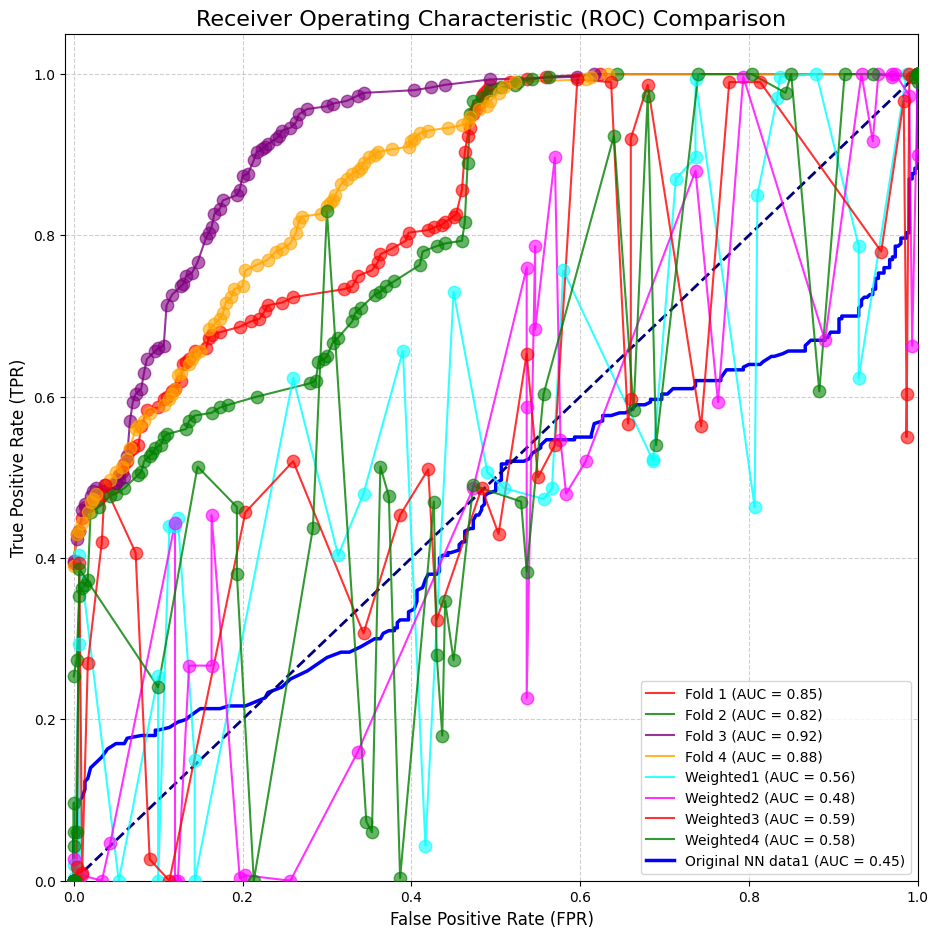

In [12]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Ensemble prediction using voting

In [13]:


# --- Loop through all the FPR values to generate the ensemble ROC curve ---

ensemble_results_soft = []
ensemble_results_hard = []

print("\n--- Generating Ensemble ROC Curve by iterating through FPR values ---")
# We iterate from a low to high target_fpr to trace the curve
for target_fpr in np.linspace(0.0, 1.0, 50): 
    # 1. Assign the function's output to a single variable first.
    result_tuple = predict_ensemble_and_evaluate(
        list_folds_best_models=list_folds_best_models,
        test_loader=test_loader,
        target_fpr=target_fpr
    )
    
    if result_tuple is not None:
        
        for voting_method, metrics in result_tuple.items():
            # Create a dictionary for each point and append it to the list
            if voting_method == 'soft_voting':
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_soft.append(point_dict)
            else:
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_hard.append(point_dict)
            
        
# Ensure the curve starts at (0, 0)
    if not ensemble_results_soft or ensemble_results_soft[0]['fpr'] > 0.0:
        ensemble_results_soft.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_soft[-1]['fpr'] < 1.0 or ensemble_results_soft[-1]['tpr'] < 1.0:
        ensemble_results_soft.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    if not ensemble_results_hard or ensemble_results_hard[0]['fpr'] > 0.0:
        ensemble_results_hard.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_hard[-1]['fpr'] < 1.0 or ensemble_results_hard[-1]['tpr'] < 1.0:
        ensemble_results_hard.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })







--- Generating Ensemble ROC Curve by iterating through FPR values ---
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0000
Soft Voting -> Achieved [TPR: 0.0000, FPR: 0.0000]
Hard Voting -> Resulted in [TPR: 0.2333, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0204
Soft Voting -> Achieved [TPR: 0.4633, FPR: 0.0200]
Hard Voting -> Resulted in [TPR: 0.4633, FPR: 0.0167]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0408
Soft Voting -> Achieved [TPR: 0.4867, FPR: 0.0400]
Hard Voting -> Resulted in [TPR: 0.4667, FPR: 0.0100]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0612
Soft Voting -> Achieved [TPR: 


--- Plotting all ROC curves for comparison ---


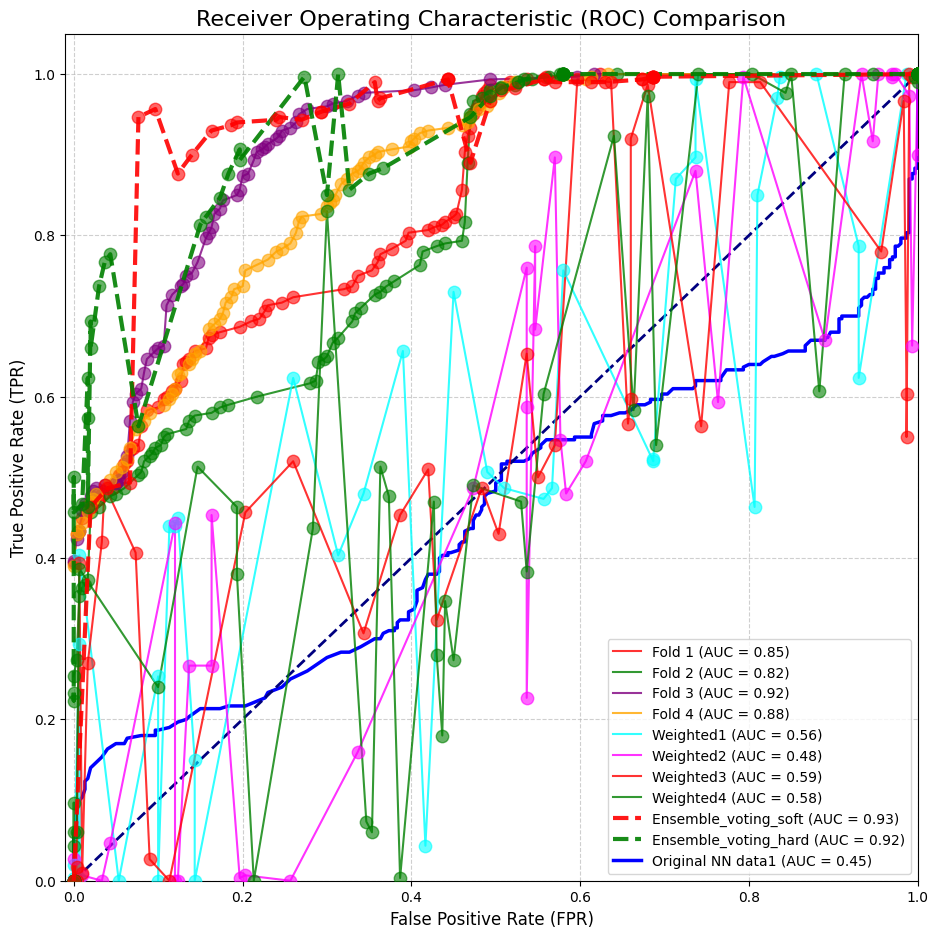

In [14]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(ensemble_results_soft)
results_lists.append(ensemble_results_hard)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Ensemble_voting_soft", "Ensemble_voting_hard"],
    results_original_roc=results_original_roc
)

## Check performances

## Check performance on test1 and test2

In [15]:
def roc_performance_tester(classifier_list, test_loader):

    list_weighted_clfs = []  # Reset the list for final testing
    for i, model_info in enumerate(classifier_list):
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}"),
            precision='16-mixed'
            )

        model = model_info["model"]
        raw_threshold = model_info["threshold"]


        # CORRECTED: Use isinstance() to check if model is a string
        if isinstance(model, str):
            print(f"Skipping model {i+1} as it is a string placeholder: '{model}'")
            continue

        # Check if the stored threshold is a NumPy number or a PyTorch Tensor
        if isinstance(raw_threshold, (np.number, torch.Tensor)):
            # If it is, we can safely call .item() to extract the Python float
            threshold = raw_threshold.item()
        else:
            # Otherwise, it's already a float or something that can be cast to one
            threshold = float(raw_threshold)
        model.current_test_threshold = threshold  # Set the threshold for this model

        # This code will now only run if 'model' is a PyTorch Lightning module
        # and not a string.
        print(f"--- Testing model {i+1} ---")

        trainer.test(model, dataloaders=test_loader, ckpt_path=None)
        
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)

    # Ensure the curve starts at (0, 0)
    if not list_weighted_clfs or list_weighted_clfs[0]['fpr'] > 0.0:
        list_weighted_clfs.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if list_weighted_clfs[-1]['fpr'] < 1.0 or list_weighted_clfs[-1]['tpr'] < 1.0:
        list_weighted_clfs.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return list_weighted_clfs